This notebooks is the quick-fix SLGA production notebook (draft) so we can fetch SLGA data.

This will hold us over until the python geodata package can be extended to work with V2 of the SLGA data sources.

In [66]:
#papermill_description=imports

import json
import os
import numpy as np
import logging
import sys
from io import StringIO

import geopandas as gpd

from gis_utils.stac import save_metadata_sidecar
from gis_utils.visualisation import get_geotiff_statistics, colour_geotiff_and_save_cog
from gis_utils.colormap import get_colormap, display_colormap_as_html

import rasterio
import requests
import rioxarray
import xarray as xr

import rasterio
from rasterio.windows import from_bounds

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# set True when locally developing, then set to False when moving to prod
local=True

In [67]:
#papermill_description=get_coords_from_geodataframe

def get_coords_from_geodataframe(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [68]:
#papermill_description= slga_metadata

#note that for now, the direct links to the COG sources have been added here. This is temporary, and these will eventually be handled by the geodata python package.

# TODO: add backup cog links incase the eoil.io ones go down.

slga_json = {
  "slga_layers": {
    "organic carbon": {
      "layer_name": "Organic_Carbon",
      "title": "Organic Carbon",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/30m/SOC/SOC_000_005_EV_N_P_AU_TRN_N_20220727_30m.tif"
    },
    "bulk density": {
      "layer_name": "Bulk_Density",
      "title": "Bulk Density",
      "si_unit": "g/cm3",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/BDW/BDW_000_005_EV_N_P_AU_TRN_N_20230607.tif"
    },
    "clay": {
      "layer_name": "Clay",
      "title": "Clay",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/CLY/CLY_000_005_EV_N_P_AU_TRN_N_20210902.tif"
    },
    "sand": {
      "layer_name": "Sand",
      "title": "Sand",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/SND/SND_000_005_EV_N_P_AU_TRN_N_20210902.tif"
    },
    "silt": {
      "layer_name": "Silt",
      "title": "Silt",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/SLT/SLT_000_005_EV_N_P_AU_TRN_N_20210902.tif"
    },
    "ph (cacl2)": {
      "layer_name": "pH_CaCl2",
      "title": "pH (CaCl2)",
      "si_unit": "pH",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/PHW/PHW_000_005_EV_N_P_AU_TRN_N_20220520.tif"
    },
    "available water capacity": {
      "layer_name": "Available_Water_Capacity",
      "title": "Available Water Capacity",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/AWC/AWC_000_005_EV_N_P_AU_TRN_N_20210614.tif"
    },
    "total nitrogen": {
      "layer_name": "Total_Nitrogen",
      "title": "Total Nitrogen",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/NTO/NTO_000_005_EV_N_P_AU_NAT_C_20231101.tif"
    },
    "total phosphorus": {
      "layer_name": "Total_Phosphorus",
      "title": "Total Phosphorus",
      "si_unit": "%",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/PTO/PTO_000_005_EV_N_P_AU_NAT_C_20231101.tif"
    },
    "effective cation exchange capacity": {
      "layer_name": "Effective_Cation_Exchange_Capacity",
      "title": "Effective Cation Exchange Capacity",
      "si_unit": "meg/100g",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/CEC/CEC_000_005_EV_N_P_AU_TRN_N_20220826.tif"
    },
    "depth of regolith": {
      "layer_name": "Depth_of_Regolith",
      "title": "Depth of Regolith",
      "si_unit": "m",
      "cog_90_source":"https://esoil.io/TERNLandscapes/Public/Products/TERN/SLGA/DES/DES_000_200_EV_N_P_AU_TRN_C_20190901.tif"
    }
  },
  "layer_depth":["0-5cm", "5-15cm", "15-30cm", "30-60cm", "60-100cm"]
}

In [69]:
#papermill_description=parameters

notebook_key = "localjupyter"
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}
propertyName = "test"
output_type = "overlay"
colormap = "viridis"
slga_layer = "Organic_Carbon"
slga_layer_depth = "0-5cm"

In [70]:
#papermill_description=process_variables

output_tiff_directory = f"/tmp/{notebook_key}"
if local:
    output_tiff_directory = "/workspace/notebooks/sandbox/data/slga_testing"

# Ensure the storage directory exists
os.makedirs(output_tiff_directory, exist_ok=True)

#initialise empty dictionary for metadata
asset_metadata={}

In [71]:
#papermill_description=processing_file_io

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

#geom = gdf.geometry #for data-harvester clip function
bounds = gdf.total_bounds

In [72]:
#papermill_description=processing_input_harvest_params

# until geodata package updated, these booleas won't have any effect
data_mask=True
add_buffer = False
resample=False

target_crs = "EPSG:3857"

# set slga_layer input to lowercase, help prevent errors from incorrect capitalisation
slga_layer = slga_layer.lower().replace("_", " ")

slga_layer_name = slga_json["slga_layers"][slga_layer]["layer_name"]
slga_cog_source = slga_json["slga_layers"][slga_layer]["cog_90_source"]

target_sources = {
    "SLGA": {
        slga_layer_name: [slga_layer_depth]
    }
}

In [73]:
#papermill_description=processing_metadata

#tiff_filename is for the raw raster streamed from the online COG. cof_tiff_filename is the COG version of the tiff file that is then used by our system.
tiff_filepath = f'SLGA_{slga_layer_name}_{slga_layer_depth}_{propertyName}_masked.tiff'
cog_tiff_filename = f'SLGA_{slga_layer_name}_{slga_layer_depth}_{propertyName}_cog.public.tiff'

output_tiff_filename = os.path.join(output_tiff_directory, tiff_filepath)
output_cog_tiff_filename = os.path.join(output_tiff_directory, cog_tiff_filename)

# get specific attribute title and si units based on the selected slga attribute.
slga_title_name = slga_json["slga_layers"][slga_layer]["title"]
unit = slga_json['slga_layers'][slga_layer]['si_unit']

# add properties to metadata
asset_metadata = {
    'properties': {
        'output_type': output_type,
        'overlay_attribute_name': slga_title_name,
        'name': f'SLGA | {slga_title_name} ({slga_layer_depth})',
    }
}

In [74]:
#papermill_description=collecting_cog_data

# Open the COG file, using the bounding box of the input polygon to create a reading window. The aoi is converted to the same CRS as the COG temporarily to get the correct bounds.
with rasterio.open(slga_cog_source) as src:
    gdf_window = gdf.to_crs(src.crs)
    bounds_window = gdf_window.total_bounds
    window = from_bounds(bounds_window[0], bounds_window[1], bounds_window[2], bounds_window[3], src.transform)
    cog_data = src.read(1, window=window)
    transform = src.window_transform(window)
    raster_crs = src.crs

In [75]:
#papermill_description=processing_cog_data

# Create an xarray DataArray from the data
raster_da = xr.DataArray(cog_data, dims=("y", "x"))
raster_da = raster_da.rio.write_transform(transform)
raster_da = raster_da.rio.write_crs(raster_crs.to_string())

# Clip the raster to the polygon
clipped_raster = raster_da.rio.clip(gdf.geometry, gdf.crs)
# Reproject the raster
reprojected_raster = clipped_raster.rio.reproject(target_crs)

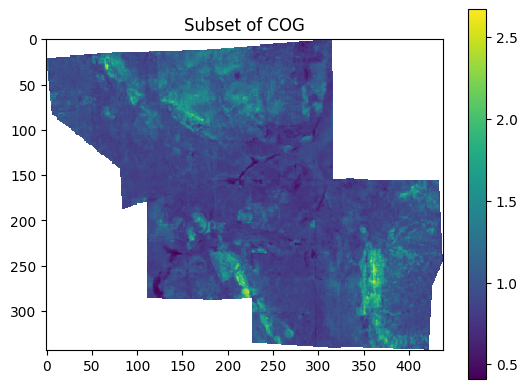

In [76]:

# Plot the data
plt.imshow(reprojected_raster, cmap='viridis')
plt.colorbar()
plt.title('Subset of COG')
plt.show()


In [77]:
#papermill_description=generate_raster_stats
raster_stats = {
    'min': float(reprojected_raster.min().values),
    'max': float(reprojected_raster.max().values),
    'mean': float(reprojected_raster.mean().values),
}

# Add stats to metadata
asset_metadata['data'] = {
    'raster_stats': raster_stats
}

In [78]:
#papermill_description=process_raster_to_rgb
# Convert data to float32 for processing
data = reprojected_raster.astype('float32')

# Handle nodata values
nodata = data.rio.nodata
if nodata is not None:
    data = data.where(data != nodata, np.nan)
else:
    data = data.where(~np.isnan(data), np.nan)

# Get the colormap
cmap = cm.get_cmap(colormap)

# Compute min and max values, excluding NaNs
min_value = np.nanmin(data.values)
max_value = np.nanmax(data.values)


# Normalize the data
norm = Normalize(vmin=min_value, vmax=max_value)
normalized_data = norm(data.values)

# Apply the colormap
coloured_data = cmap(normalized_data)  # Shape: (y, x, 4)

# Convert the color data to uint8 and exclude the alpha channel
coloured_data = (coloured_data[:, :, :3] * 255).astype('uint8')  # Shape: (y, x, 3)

# Transpose the data to have dimensions (band, y, x)
coloured_data = coloured_data.transpose(2, 0, 1)  # Shape: (band, y, x)

# Create a new DataArray for the RGB data
rgb_da = xr.DataArray(
    data=coloured_data,
    dims=('band', 'y', 'x'),
    coords={
        'band': [1, 2, 3],
        'y': data['y'],
        'x': data['x']
    },
    attrs=reprojected_raster.attrs
)

# Write the CRS and transform information
rgb_da = rgb_da.rio.write_crs(target_crs)
rgb_da = rgb_da.rio.write_transform(reprojected_raster.rio.transform())

# Explicitly set the nodata value to 0 and write it to the DataArray
rgb_da = rgb_da.rio.write_nodata(0, inplace=True)

/usr/local/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/tmp/ipykernel_12820/1566324312.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


In [79]:
#papermill_description=save_cog_tiff

rgb_da.rio.to_raster(
    output_cog_tiff_filename,
    driver='COG',
    compress='deflate',
    dtype='uint8',
    nodata=0,
    tiled=True,
    overwrite=True
)

In [80]:
# #papermill_description=saving_raw_cog_data

# reprojected_raster.rio.to_raster(
#     output_tiff_filename,
#     compress="deflate",
#     driver="COG"
# )

In [81]:
#papermill_description=coloring_cog_and_processing_colormap


# generate the colormap for the legend
#colormap_legend = get_colormap(colormap, [-1,  1], 21)
colormap_legend = get_colormap(colormap, [raster_stats['min'], raster_stats['mean'],  raster_stats['max']], 21, 3)

display_colormap_as_html(colormap_legend)

# add colormap to metadata
asset_metadata['legend'] = {
    'colormap': {
        'type': 'discrete',
        'colors': colormap_legend
    },
    'unit': unit
}

asset_metadata['properties']['overlayType'] = 'SLGA'

save_metadata_sidecar(output_cog_tiff_filename, asset_metadata)

Metadata saved to /workspace/notebooks/sandbox/data/slga_testing/SLGA_Organic_Carbon_0-5cm_test_cog.public.tiff.meta.json
